# Svensson (1994)



$$ r(t) = \beta_1 + \beta_2\frac{1-e^{-\lambda_1 t}}{\lambda_1 t} 
        + \beta_3 \left(\frac{1-e^{-\lambda_1 t}}{\lambda_1 t}-e^{-\lambda_1 t}\right)
        + \beta_4 \left(\frac{1-e^{-\lambda_2 t}}{\lambda_2 t}-e^{-\lambda_2 t}\right)$$

### Importing the data

In [26]:
from scipy.optimize import fmin
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from bizdays import Calendar
import os

path = r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\ETTJ"

df = pd.read_excel(os.path.join(path, "Titulos.xlsx"))
parameters = pd.read_excel(os.path.join(path, "Parametros.xlsx"))
selic = pd.read_excel(os.path.join(path, "SELIC.xlsx"))


#### Maturity and Coupon Calculation


In [27]:
### Selic treatments
cal = Calendar.load("ANBIMA")
parameters.set_index("Data referência", inplace=True)

In [ ]:
### Selic treatments
cal = Calendar.load("ANBIMA")
parameters.set_index("Data referência", inplace=True)

selic.rename(columns={'Data': 'DATA_REFERENCIA'}, inplace=True)
selic.rename(columns={'CDI': 'EXPECTATIVA'}, inplace=True)
selic["CODIGO"]="SELIC"
selic["DATA_VENCIMENTO"]=cal.offset(selic["DATA_REFERENCIA"],1)
selic["PU"]=1000/((1+selic['EXPECTATIVA'])**(1/252))
selic = selic[["CODIGO",'DATA_REFERENCIA',"DATA_VENCIMENTO",'EXPECTATIVA',"PU"]]
df = pd.concat([df, selic], ignore_index=True)

In [28]:
### Maturity Calculation

df["Maturity"] = np.array(cal.bizdays(df["DATA_REFERENCIA"], df["DATA_VENCIMENTO"]))/252

### Coupon Calculation

df['Coupon'] = np.where(df['CODIGO'] == 'NTN-F', 10, 0)

# Function to generate the number of coupon days between two dates
def calculate_coupon_days(reference_date, maturity_date):
    first_january = pd.Timestamp(reference_date).replace(month=1, day=1)
    first_july = pd.Timestamp(reference_date).replace(month=7, day=1)
    
    coupon_dates = [first_january, first_july]
    
    next_january = first_january + pd.DateOffset(years=1)
    next_july = first_july + pd.DateOffset(years=1)
    
    while next_january <= maturity_date:
        coupon_dates.append(next_january)
        coupon_dates.append(next_july)
        next_january = next_january + pd.DateOffset(years=1)
        next_july = next_july + pd.DateOffset(years=1)
    
    coupon_days = [cal.bizdays(reference_date, coupon_date) for coupon_date in coupon_dates if coupon_date >= reference_date and coupon_date <= maturity_date]
    return coupon_days

# Função para calcular os cupons
def calculate_coupons(row):
    if row["CODIGO"] != "NTN-F":
        return np.zeros(0, dtype=int)  # Retorna um array vazio se não for "NTN-F"
    else:
        return np.array(calculate_coupon_days(row['DATA_REFERENCIA'], row['DATA_VENCIMENTO']), dtype=int)

# Duration

df["Coupons_days"] = df.apply(calculate_coupons, axis=1)

def sum_duration(row):
    return np.sum(row)

df['Duration'] = 1000 * ((1 + 0.1) ** (1 / 2) - 1) / ((1 + df['EXPECTATIVA'] / 100) ** (df['Coupons_days'] / 252)) * (df['Coupons_days'] / 252)
payment = 1000 / ((1 + df['EXPECTATIVA'] / 100) ** df['Maturity']) * df['Maturity']
df['Duration'] = (df['Duration'].apply(sum_duration) + payment) / df['PU']

df.set_index("DATA_REFERENCIA", inplace=True)


### Generating individuals

In [31]:
df

,CODIGO,DATA_VENCIMENTO,EXPECTATIVA,PU,Maturity,Coupon,Coupons_days,Duration
DATA_REFERENCIA,,,,,,,,
2001-12-03,LTN,2001-12-05,19.261162,998.602996,0.007937,0,[],0.007937
2001-12-03,LTN,2002-01-09,19.460505,982.514242,0.099206,0,[],0.099206
2001-12-03,LTN,2002-02-06,19.798967,968.256726,0.178571,0,[],0.178571
2001-12-03,LTN,2002-04-03,20.499098,941.126777,0.325397,0,[],0.325397
2001-12-03,LTN,2002-05-01,20.862030,926.869810,0.400794,0,[],0.400794
...,...,...,...,...,...,...,...,...
2023-08-02,NTN-F,2025-01-01,10.775300,998.588004,1.412698,10,"[102, 227, 356]",1.343162
2023-08-02,NTN-F,2027-01-01,10.192000,1003.263292,3.408730,10,"[102, 227, 356, 479, 609, 732, 859]",2.955236
2023-08-02,NTN-F,2029-01-01,10.522000,989.244392,5.392857,10,"[102, 227, 356, 479, 609, 732, 859, 983, 1110,...",4.269909


In [187]:
df = save
df

,CODIGO,DATA_VENCIMENTO,EXPECTATIVA,PU,Maturity,Coupon,Coupons_days,Duration
DATA_REFERENCIA,,,,,,,,
2001-12-03,LTN,2001-12-05,19.261162,998.602996,0.007937,0,[],0.007937
2001-12-03,LTN,2002-01-09,19.460505,982.514242,0.099206,0,[],0.099206
2001-12-03,LTN,2002-02-06,19.798967,968.256726,0.178571,0,[],0.178571
2001-12-03,LTN,2002-04-03,20.499098,941.126777,0.325397,0,[],0.325397
2001-12-03,LTN,2002-05-01,20.862030,926.869810,0.400794,0,[],0.400794
...,...,...,...,...,...,...,...,...
2023-08-02,NTN-F,2025-01-01,10.775300,998.588004,1.412698,10,"[102, 227, 356]",1.343162
2023-08-02,NTN-F,2027-01-01,10.192000,1003.263292,3.408730,10,"[102, 227, 356, 479, 609, 732, 859]",2.955236
2023-08-02,NTN-F,2029-01-01,10.522000,989.244392,5.392857,10,"[102, 227, 356, 479, 609, 732, 859, 983, 1110,...",4.269909


In [188]:
save = df
#df = save
ref_date_str = "2023-07-27"

N =1200             ### Number of individuals 
p = int(2/3*N)      ### Proportion of individuals generated by method 1
var = 0.25           ### variance normal distribution

### 1 - Initial Values of the results of the estimation of the previous day


ref_date = datetime.strptime(ref_date_str, "%Y-%m-%d")
previous_date = cal.offset(ref_date_str,-1)
previous_parameters = parameters.loc[str(previous_date)][1:]
beta_star_1 = np.array([previous_parameters.replace(previous_parameters[1],previous_parameters[0])])
e_previous = beta_star_1.T*np.random.normal(0, var, size=(6, p))
beta_previous = beta_star_1.T + e_previous

### 2 - Approximation that takes into account the observed yield to maturity (ytm)

data_estimada = df.loc[ref_date_str]
data_estimada=data_estimada.sort_values("Maturity")
diferencas_absolutas = (data_estimada['Duration'] - 1).abs()
b1 = data_estimada.iloc[np.argmin(diferencas_absolutas)]["EXPECTATIVA"]/100
b2 =  data_estimada.iloc[np.argmin(diferencas_absolutas)]["EXPECTATIVA"]/100 - data_estimada["EXPECTATIVA"][-1]/100
b3 = 0
b4 = 0
lbda1 = previous_parameters[4]
lbda2 = previous_parameters[5]
#lbda1 = (data_estimada["Maturity"][-1]-data_estimada["Maturity"][0])/2
#lbda2 = lbda1
beta_star_2 = np.array([b1, b2, b3 , b4, lbda1, lbda2])[:, np.newaxis]
e_approx = beta_star_2*np.random.normal(0, var, size=(6, N-p))
beta_approx = beta_star_2 + e_approx ## ajustar colunas

### Adding constraints to the parameters

def update (betas,beta_star):
    updated_value = []
    for index, parameter in enumerate(betas):
        if parameter[0]<0:
            betas[index][0] = beta_star[0]+ beta_star[0]*np.random.normal(0, var)
            updated_value.append(betas[index][0]<0)
        if (parameter[0]+parameter[1])<0:
            betas[index][1] = beta_star[1]+ beta_star[1]*np.random.normal(0, var)
            updated_value.append((betas[index][0]+betas[index][1])<0)
        if parameter[4]<0 or parameter[4]>10:
            betas[index][4] = beta_star[4]+ beta_star[4]*np.random.normal(0, var)
            updated_value.append(betas[index][4]<0)
        if parameter[5]<0 or parameter[5]>10:
            betas[index][5] = beta_star[5]+ beta_star[5]*np.random.normal(0, var)
            updated_value.append(betas[index][5]<0)
    if sum(updated_value) != 0:
        update(betas,beta_star)
        
    return(betas)

update(beta_previous.T,beta_star_1.T)
update(beta_approx,beta_star_2)

individuals = np.concatenate((beta_previous.T, beta_approx.T), axis=0)

In [189]:
data_estimada

,CODIGO,DATA_VENCIMENTO,EXPECTATIVA,PU,Maturity,Coupon,Coupons_days,Duration
DATA_REFERENCIA,,,,,,,,
2023-07-27,LTN,2023-10-01,13.1755,977.660457,0.178571,0,[],0.178659
2023-07-27,LTN,2024-01-01,12.6150,950.806347,0.420635,0,[],0.420833
2023-07-27,LTN,2024-04-01,12.0162,927.141688,0.666667,0,[],0.666667
2023-07-27,LTN,2024-07-01,11.4405,905.476539,0.916667,0,[],0.916667
2023-07-27,LTN,2024-10-01,10.9584,884.658175,1.178571,0,[],1.178571
2023-07-27,LTN,2025-01-01,10.6135,865.452245,1.428571,0,[],1.429143
2023-07-27,NTN-F,2025-01-01,10.7089,997.781958,1.428571,10,"[106, 231, 360]",1.359071
2023-07-27,LTN,2025-04-01,10.4703,846.410208,1.674603,0,[],1.674603
2023-07-27,LTN,2025-07-01,10.3323,828.234301,1.916667,0,[],1.916667


### Selection

In [190]:
df = data_estimada
alpha = 6
var = 0.25
pi = 0.35
### 40% of the individuals survive
s = int(0.4 * N)
mty = df['Maturity'].values.reshape(-1, 1)
price = df['PU']
cp_days = df['Coupons_days']
duration = df["Duration"].values.reshape(-1, 1)


# Vetorização da geração de next_gen
def generate_next_gen(selection):
    psi = np.random.uniform(0, 1, N)
    selected_rows1 = selection.iloc[(np.random.beta(1, alpha, N) * s)]
    selected_rows1.reset_index(drop=True, inplace=True)
    selected_rows2 = selection.iloc[(np.random.beta(1, alpha, N) * s)]
    selected_rows2.reset_index(drop=True, inplace=True)
    theta_r = selected_rows1["Parameters"]
    theta_s = selected_rows2["Parameters"]
    next_gen = psi * theta_r + (1 - psi) * theta_s
    e = np.random.choice([0, 1], size=(6, N), p=[1 - pi, pi]) * np.random.normal(0, var, size=(6, N))
    next_gen_list = next_gen.tolist()
    next_gen_array = np.array(next_gen_list)
    update(next_gen_array, beta_star_1.T)
    new_individuals = next_gen_array * e.T + next_gen_array
    return new_individuals



for iteration in range(200):
    
    beta1 = individuals[:,0].reshape(-1, 1)
    beta2 = individuals[:,1].reshape(-1, 1)
    beta3 = individuals[:,2].reshape(-1, 1)
    beta4 = individuals[:,3].reshape(-1, 1)
    lambda1 = individuals[:,4].reshape(-1, 1)
    lambda2 = individuals[:,5].reshape(-1, 1)
    print(iteration)
    
    nss = beta1+beta2*((1-np.exp(-lambda1*mty.T))/(lambda1*mty.T))+beta3*((1-np.exp(-lambda1*mty.T))/(lambda1*mty.T)-np.exp(-lambda1*mty.T))+beta4*((1-np.exp(-lambda2*mty.T))/(lambda2*mty.T)-np.exp(-lambda2*mty.T))
    calculated_price = 1000 / (1+nss)**mty.T


    for row,index in enumerate(nss):
        calculated_coupon = 1000 * ((1 + 0.1) ** (1 / 2) - 1) / (1 + nss[row]) ** (cp_days.T / 252)
        calculated_coupon = calculated_coupon.apply(sum_duration)
        calculated_coupon
        calculated_price[row] = calculated_price[row] + calculated_coupon

    residual = (1/duration.T)*(np.tile(price.T, (1200, 1))-calculated_price)**2
    sc = np.sum(residual, axis=1)
    data = {
        'SC': sc,
        'Parameters': individuals.tolist()  # Converta o array NumPy em uma lista
    }

    sol = pd.DataFrame(data)

    selection = sol.sort_values('SC')[0:s]
    selection['Parameters'] = selection['Parameters'].apply(np.array)
    
    if iteration > 1:
        var = 0.25 * 1.02
    
    new_individuals = generate_next_gen(selection)
    
    individuals = new_individuals

selection.head()



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


,SC,Parameters
37,2.876908,"[0.11411564206865801, 0.023085646438925175, 0...."
495,2.880632,"[0.1141135491108865, 0.02366553555180857, 0.05..."
253,2.881512,"[0.114115501787982, 0.022902943170934532, 0.05..."
1020,2.883476,"[0.11411821532344642, 0.022880157536682728, 0...."
420,2.887673,"[0.11411247448018716, 0.023405837636042245, 0...."


In [191]:
dia = selection.iloc[0]["Parameters"]
dia_anbima = parameters.loc[ref_date][1:]
print(dia.round(2))
print(dia_anbima)

[ 0.11  0.02  0.05 -0.08  3.27  1.19]
Beta 1      0.116078
Beta 2      0.016613
Beta 3       0.06809
Beta 4     -0.099364
Lambda 1    2.699952
Lambda 2     1.22983
Name: 2023-07-27 00:00:00, dtype: object


Text(0.5, 1.0, '2023-07-27 00:00:00')

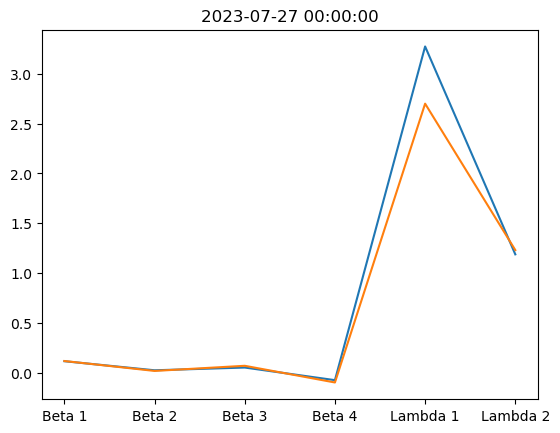

In [192]:
rounded_series = selection["Parameters"].apply(lambda lst: [round(x, 1) for x in lst])
rounded_series[0:99]
plt.plot(dia)
plt.plot(dia_anbima)
plt.title(f'{ref_date}')

In [193]:
datinha = pd.DataFrame(dia)
nome_do_arquivo = 'dados.xlsx'
datinha.to_excel(nome_do_arquivo, index=False)